In [24]:
%load_ext autoreload
%autoreload 2

import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

if 'cachai' not in os.listdir('.'):
    os.chdir('../')

import cachai.utils.models as M
import cachai.utils.constants as C
from cachai.simulator.advanced_simulator import CustomAdvancedSimulator
import cachai.simulator.generators.record_generator as RecordGenerator
import cachai.simulator.generators.record_sampler as RecordSampler
import cachai.simulator.generators.traffic_generator as TrafficGenerator
import cachai.simulator.generators.feature_generator as FeatureGenerator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
RecordGenerator.generate_record_payload(count=2, payload_length=20)

[{'attribute_1': 'rp5hxj565qm4splxwtfx'},
 {'attribute_2': '42ysz3vjruu0al3itkle'}]

In [26]:
record_keys, records_dict = RecordGenerator.generate_records(
    records_count=10,
    generate_record_payload=lambda: RecordGenerator.generate_record_payload(count=2, payload_length=20)
)

print('Record keys:')
print(record_keys)
print()
print('Records dict:')
print(records_dict)

Record keys:
['yfmu29e9tc' 'jemio51au8' 'nu6uexlamn' '298si38cgt' 'ixtcmodzjs'
 'lur7ll5cyl' 'seqg1pg8b8' '1qxgw74iys' '7tmhhs9me2' 'mwnu3rgm9w']

Records dict:
{'yfmu29e9tc': [{'attribute_1': '2zuh9otna6eelohs82k3'}, {'attribute_2': 'bcsbscvd2khpegzjl6iz'}], 'jemio51au8': [{'attribute_1': 'glwuze9p566gnn7hqvw0'}, {'attribute_2': 'zutdw3hmgzfh63kps1iw'}], 'nu6uexlamn': [{'attribute_1': '2jm664h4ohc8qgqslfu1'}, {'attribute_2': 'yq5hx5yx3eyxivrje4zn'}], '298si38cgt': [{'attribute_1': '18o41uzver35jqu5oivm'}, {'attribute_2': 'tbl9sfkf0non7hgviwx3'}], 'ixtcmodzjs': [{'attribute_1': '3xiifhyj177hz7gk7myx'}, {'attribute_2': 'ckubthw82qmenulyvkz4'}], 'lur7ll5cyl': [{'attribute_1': '9xsi93eskj3njkkhlvre'}, {'attribute_2': 'reuaothpx9zzxt80j2uo'}], 'seqg1pg8b8': [{'attribute_1': 'cb15g2zjztybcl3zcbmc'}, {'attribute_2': 'q42g0ok33rkipkk2l8k2'}], '1qxgw74iys': [{'attribute_1': 'l9zds8d4ym7ou6t193d4'}, {'attribute_2': '00navooijiztpmts89tc'}], '7tmhhs9me2': [{'attribute_1': 'atr68jgqvgqfjbv9d4hb'}

In [27]:
px.histogram(
    x=RecordSampler.uniform(record_keys, count=1_000),
    title='Records with uniform sampling',
    category_orders={'x': record_keys},
    labels={'x': 'Record key'},
    template='plotly_dark'
).show()

In [28]:
fig = go.Figure()

means = [0.25, 0.5, 0.75]
for mean in means:
    sample = RecordSampler.normal(record_keys, count=500, mean=mean, std=0.1)
    fig.add_trace(go.Histogram(
        x=sample,
        name=f'Mean: {mean}',
    ))

fig.update_layout(
    title='Records with normal sampling and different means',
    xaxis_title='Record',
    yaxis_title='Volume',
    showlegend=True,
    template='plotly_dark',
    xaxis={
        'categoryorder': 'array',
        'categoryarray': record_keys
    }
).show()

In [29]:
alphas = [-2.0, -1.0, 0.0, 1.0, 2.0]
samples = [RecordSampler.zipf(record_keys, count=1_000, alpha=a, return_probs=True) for a in alphas]

fig = go.Figure()
for i, (sample, probs) in enumerate(samples):
    fig.add_trace(go.Scatter(
        x=record_keys,
        y=probs,
        mode='lines+markers',
        name=f'alpha = {alphas[i]}'
    ))

fig.update_layout(
    title='Records with Zipf sampling and varying alphas',
    xaxis_title='Record',
    yaxis_title='Probability',
    showlegend=True,
    template='plotly_dark',
    xaxis={
        'categoryorder': 'array',
        'categoryarray': record_keys
    }
).show()

In [30]:
for i in np.linspace(0.0, 1.0, 5):
    px.histogram(
        x=RecordSampler.periodic_zipf(
            record_keys,
            count=1_000,
            alpha=2,
            periods_count=1,
            progress=i
        ),
        title=f'Records with periodic Zipf sampling and progress: {i}',
        category_orders={'x': record_keys},
        labels={'x': 'Record key'},
        template='plotly_dark'
    ).show()

In [31]:
operations = TrafficGenerator.sample_operations(count=1_000, operations=[
    TrafficGenerator.Operation(C.READ),
    TrafficGenerator.Operation(C.UPDATE),
    TrafficGenerator.Operation(C.DATA_CHANGED)
], probs=[0.5, 0.3, 0.2])

px.histogram(
    title='Choosing operations based on a PDF',
    x=[o.type for o in operations],
    labels={'x': 'Operation Type'},
    template='plotly_dark'
).show()

In [32]:
traffic = TrafficGenerator.generate_traffic(
    start='01-01-2024 00:00:00',
    end='01-05-2024 00:00:00',
    freq='h',
    count=20_000,
)

px.histogram(
    x=traffic,
    title='Simulated traffic volume',
    labels={'x': 'Time'},
    template='plotly_dark',
).show()

In [33]:
simulator = CustomAdvancedSimulator(M.TTLSimulatorConfig(records_count=3, operations_count=10000))
simulator.generate()

In [34]:
px.histogram(
    x=simulator.run_phase_df[C.TIMESTAMP],
    title='Simulated traffic volume',
    labels={'x': 'Time'},
    template='plotly_dark',
).show()

In [36]:
progress_range = np.linspace(0.0, 1.0, 6)
for i in progress_range:
    increment = 1/(len(progress_range)-1)
    start_slice = round(simulator.operations_count * i)
    end_slice = round(simulator.operations_count * (i+increment))
    if end_slice > simulator.operations_count:
        break
    sliced_run_phase = simulator.run_phase_df[start_slice:end_slice]
    updates_filter = sliced_run_phase['operation'] == C.DATA_CHANGED
    px.histogram(
        x=sliced_run_phase[C.RECORD][updates_filter],
        title=f'Record samples: {start_slice} - {end_slice}',
        labels={'x': 'Record'},
        template='plotly_dark',
        category_orders={'x': simulator.record_keys}
    ).show()

In [ ]:
px.histogram(
    simulator.run_phase_df,
    title='Record distribution',
    x=C.RECORD,
    color=C.OPERATION,
    category_orders={C.RECORD: simulator.record_keys},
    template='plotly_dark'
).show()

In [ ]:
px.histogram(
    simulator.run_phase_df,
    x=C.TIMESTAMP,
    color=C.OPERATION,
    title='Operations distribution across time',
    labels={'x': 'Time', 'y': 'Traffic count'},
    template='plotly_dark'
).show()

In [37]:
px.scatter(
    simulator.run_phase_df,
    title='Records over time',
    x=C.TIMESTAMP,
    y=C.RECORD,
    category_orders={C.RECORD: list(reversed(simulator.record_keys))},
    color=C.OPERATION,
    template='plotly_dark'
).show()

In [ ]:
px.scatter(
    simulator.run_phase_df,
    title='Records over operation index',
    x=simulator.run_phase_df.index,
    y=C.RECORD,
    category_orders={C.RECORD: list(reversed(simulator.record_keys))},
    color=C.OPERATION,
    template='plotly_dark'
).show()

In [38]:
positive_y_true_df = simulator.run_phase_df[simulator.run_phase_df[C.Y_TRUE] > 0]
px.histogram(
    positive_y_true_df,
    x=C.Y_TRUE,
    title='Gold TTL distribution',
    labels={'x': 'Gold TTL', 'y': 'Frequency'},
    color=C.RECORD,
    category_orders={C.RECORD: simulator.record_keys},
    template='plotly_dark',
).show()

In [39]:
px.box(
    positive_y_true_df,
    y=C.Y_TRUE,
    title='Gold TTL statistics',
    labels={'y': 'Gold TTL'},
    color=C.RECORD,
    category_orders={C.RECORD: simulator.record_keys},
    template='plotly_dark'
).update_traces(boxmean=True).show()

In [40]:
px.scatter(
    simulator.run_phase_df,
    x=C.TIMESTAMP,
    y=C.Y_TRUE,
    title='Gold TTL over time',
    labels={'x': 'Time', 'y': 'Gold TTL'},
    color=C.RECORD,
    category_orders={C.RECORD: simulator.record_keys},
    template='plotly_dark'
).show()

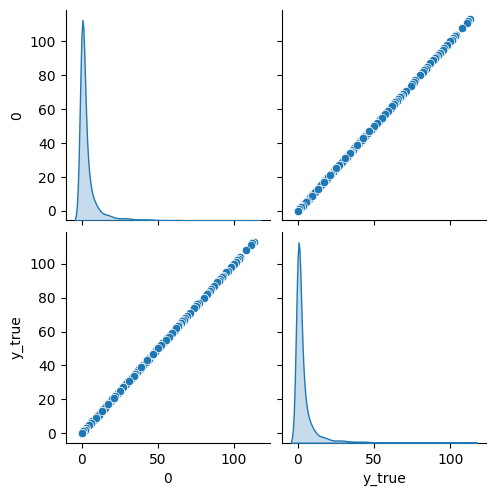

In [41]:
sns.pairplot(
    simulator.features_df,
    diag_kind="kde"
)